### Whisper

important points:
```text
All audio is re-sampled to 16,000 Hz, and an 80-channel log-magnitude Mel spectrogram representation is computed on 25-millisecond windows with a stride of 10 milliseconds.

Whisper models are trained on 30-second audio chunks and cannot consume longer audio inputs at once

In [1]:
from typing import List, Dict, Optional
import torch
import torchaudio
import os
from datasets import load_dataset

import sys
sys.path.append("/home/arunima/ASR/whisper")
import whisper
from whisper import DecodingOptions

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class LibriSpeech(torch.utils.data.Dataset):
    """
    A simple class to wrap LibriSpeech and trim/pad the audio to 30 seconds.
    It will drop the last few seconds of a very small portion of the utterances.
    """
    def __init__(self, split="test-clean", device=DEVICE):
        self.dataset = torchaudio.datasets.LIBRISPEECH(
            root=os.path.expanduser("~/.cache"),
            url=split,
            download=True,
        )
        self.device = device

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        audio, sample_rate, text, _, _, _ = self.dataset[item]
        assert sample_rate == 16000
        audio = whisper.pad_or_trim(audio.flatten()).to(self.device)
        mel = whisper.log_mel_spectrogram(audio)
        
        return [mel, text]
    

In [2]:
dataset = LibriSpeech("test-clean")
# loader = torch.utils.data.DataLoader(dataset,batch_size=2)
loader = [dataset.__getitem__(i) for i in range(0,2)]

ModelDimensions(n_mels=80, n_audio_ctx=1500, n_audio_state=384, n_audio_head=6, n_audio_layer=4, n_vocab=51865, n_text_ctx=448, n_text_state=384, n_text_head=6, n_text_layer=4)


  0%|          | 0/2 [00:00<?, ?it/s]

Target text: HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE
Mel shape: torch.Size([80, 3000])


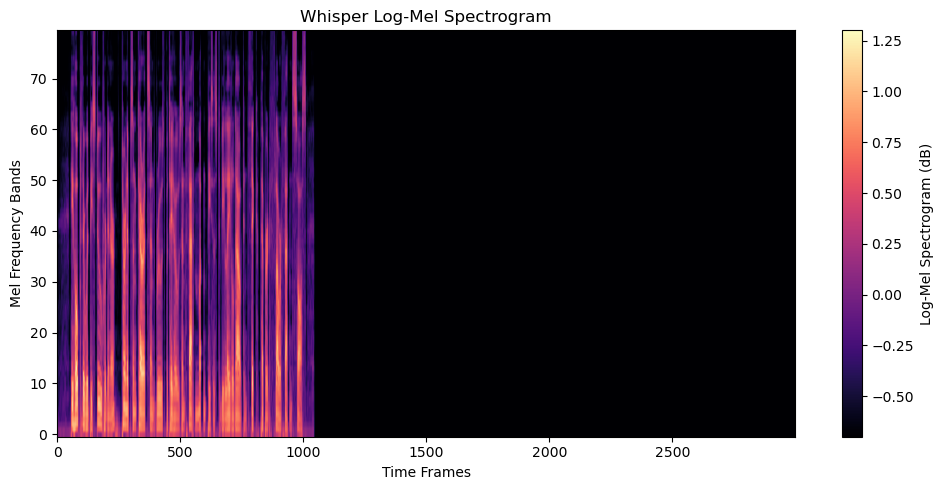

baseline logits shape: torch.Size([224, 51865])
pos= 4 He hoped there would be stew for dinner, turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick, peppered flower-fat and sauce.


/tmp/ipykernel_16761/1761055278.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(baseline_logits[token_idx]), reduction='mean')for token_idx,logit_per_token in enumerate(logits_perturbed)]))


pos= 5 He hoped there would be stew for dinner, turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick, peppered flower-fat and sauce.
pos= 6 He hoped there would be stew for dinner, turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick, peppered flower-fat and sauce.
pos= 7 He hoped there would be stew for dinner, turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick, peppered flower-fat and sauce.
pos= 8 He hoped there would be stew for dinner, turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick, peppered flower-fat and sauce.
pos= 9 He hoped there would be stew for dinner, turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick, peppered flower-fat and sauce.
pos= 10 He hoped there would be stew for dinner, turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick, peppered flower-

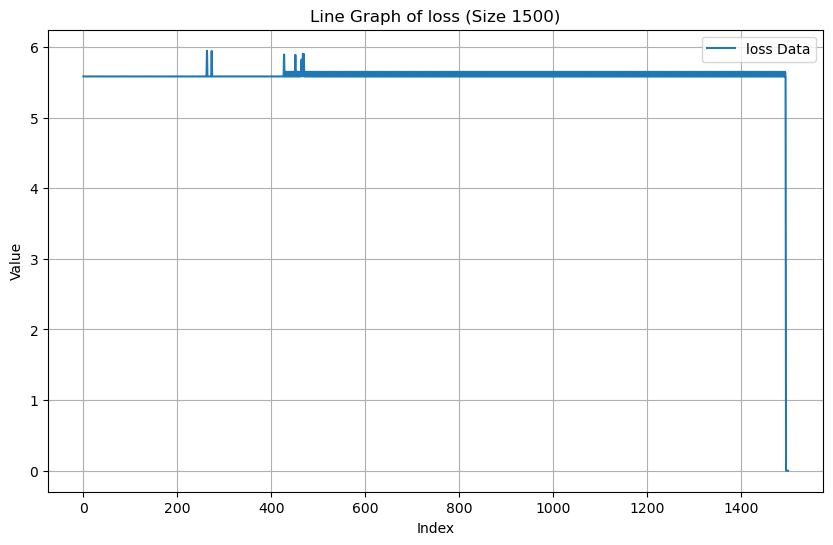

Target text: STUFF IT INTO YOU HIS BELLY COUNSELLED HIM
Mel shape: torch.Size([80, 3000])


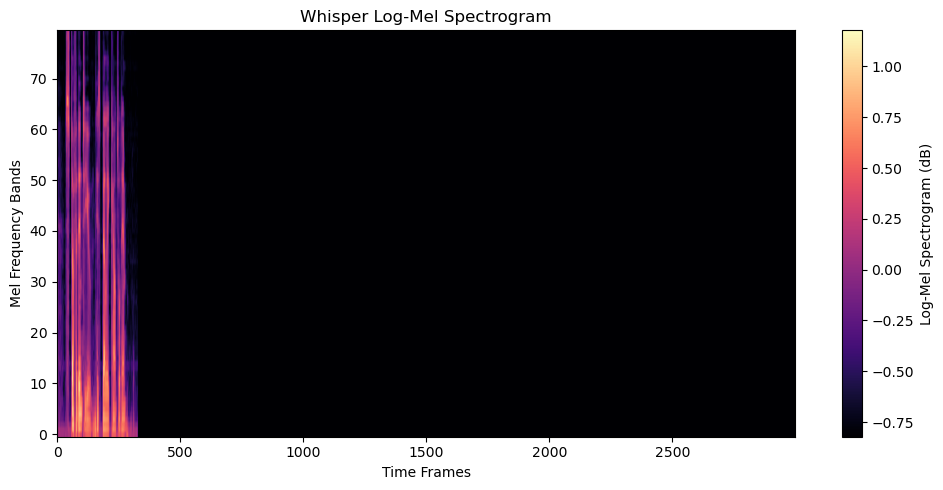

baseline logits shape: torch.Size([224, 51865])
pos= 4 Stuff it into you, his belly couched him.
pos= 5 Stuff it into you, his belly couched him.
pos= 6 Stuff it into you, his belly couched him.
pos= 7 Stuff it into you, his belly couched him.
pos= 8 Stuff it into you, his belly couched him.
pos= 9 Stuff it into you, his belly couched him.
pos= 10 Stuff it into you, his belly couched him.
pos= 11 Stuffed into you, his belly, cowtled him.
pos= 12 Stuffed into you, his belly, cowtled him.
pos= 13 Stuffed into you, his belly, cowtled him.
pos= 14 Stuffed into you, his belly, cowtled him.
pos= 15 Stuffed into you, his belly, cowtled him.
pos= 16 Stuffed into you, his belly, cowtled him.
pos= 17 Stuffed into you, his belly, cowtled him.
pos= 18 Stuffed into you, his belly, cowtled him.
pos= 19 Stuffed into you, his belly, cowtled him.
pos= 20 Stuffed into you, his belly, cowtled him.
pos= 21 Stuffed into you, his belly, cowtled him.
pos= 22 Stuffed into you, his belly, cowtled him.
pos= 23 

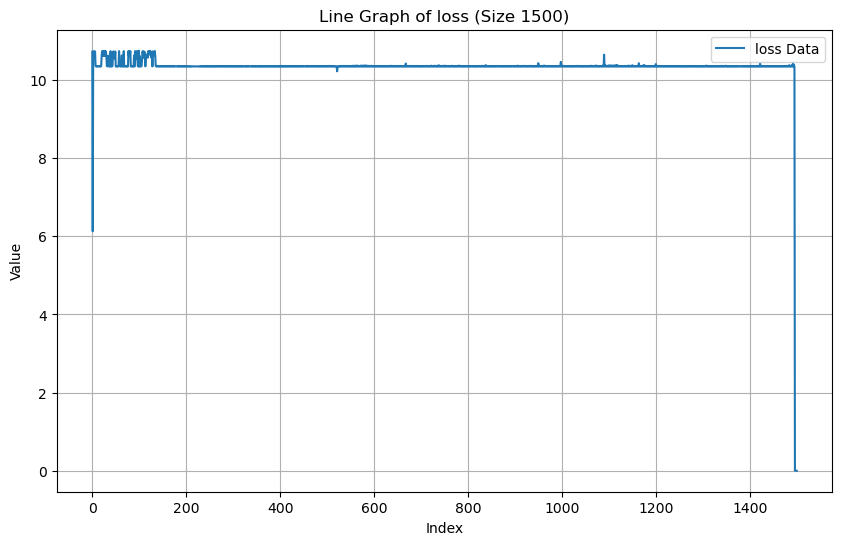

In [ ]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

# Display the Log-Mel spectrogram
def display_logmel(mel):

    if mel.ndim == 3:
        mel = np.squeeze(mel)
    plt.figure(figsize=(10, 5))
    plt.imshow(mel, aspect="auto", origin="lower", cmap="magma")
    plt.colorbar(label="Log-Mel Spectrogram (dB)")
    plt.title("Whisper Log-Mel Spectrogram")
    plt.xlabel("Time Frames")
    plt.ylabel("Mel Frequency Bands")
    plt.tight_layout()
    plt.show()


def plot_logits(data):
    plt.figure(figsize=(10, 6))
    plt.plot(data.cpu().numpy(), label="loss Data")
    plt.title("Line Graph of loss (Size 1500)")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    plt.show()

model = whisper.load_model("tiny")


flag = 0



for mels, target_text in tqdm(loader):
    print('Target text:', target_text)
    print('Mel shape:', mels.shape)
    display_logmel(mels.cpu().numpy())

    baseline_logits = model.decode(mels).logits
    print('baseline logits shape:',baseline_logits.shape)

    n_positions = model.dims.n_audio_ctx
    loss_diff = torch.zeros(n_positions).to(DEVICE)


    for pos in range(n_positions-5):
        # Create a perturbation dictionary: suppress suppression_index at position `pos`
        for i in range(pos,pos+5):
            suppression_dict = {i: 0.5,}  # Suppress with factor 0.0 (remove the contribution)
        options = DecodingOptions(fp16 = False,language='english', perturbation=True, perturbation_tokens=suppression_dict)
        
        decoded = model.decode(mels,options)
        # Forward pass with perturbation
        print('pos=',i,decoded.text)
        logits_perturbed = decoded.logits
        # print(logits_perturbed.shape,logits_perturbed[0].shape)
        perturbed_loss = torch.mean(torch.Tensor([F.cross_entropy(logit_per_token,
                                         F.softmax(baseline_logits[token_idx]), reduction='mean')for token_idx,logit_per_token in enumerate(logits_perturbed)]))

        # Compute loss difference
        loss_diff[pos] = perturbed_loss

    # print(loss_diff.shape)
    plot_logits(loss_diff)

   # results = explain_whisper_tokens(model=model,mel=mels, tokens= target_tokens, suppression_dict = suppression_dict, prompt_explain_indices=prompt_explain_indices, max_batch_size=max_batch_size )
    if flag != 1:
        flag +=1
    else :
        break






#TODO:
Graph analysis
run it for all 1500 - restricting the seq acc to audio size
robustness for seq len and suppression size
roman.bartolosch@gmail.com
one plot one word - how each word is getting effected bcoz of suppression index
length of perturbation
suppression factor - change
gaussian overlap on supression

